In [1]:
%run ./../data/load-dataset.ipynb
%run ./../various/_epoch_callback.ipynb
%matplotlib inline

2022-02-19 03:01:06,686 - __main__ - INFO - Loading dataset from disk...
2022-02-19 03:01:18,445 - __main__ - INFO - Dataset loaded.
2022-02-19 03:01:18,447 - __main__ - INFO - Preprocessing the dataset...
2022-02-19 03:06:34,151 - __main__ - INFO - Dataset preprocessed.
2022-02-19 03:06:34,151 - __main__ - INFO - Subsampling the dataset...
2022-02-19 03:06:34,828 - __main__ - INFO - Dataset subsampled.
2022-02-19 03:06:56,687 - __main__ - INFO - Saving preprocessed dataset to disk...
2022-02-19 03:07:03,528 - __main__ - INFO - Preprocessed dataset saved to disk.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, RNN, GRU, LSTM, Dense, Dropout, ReLU

In [3]:
ITERS = 10
MAX_LENGTH = MIN_LENGTH + 200

RANDOM_SEED = 0
if RANDOM_SEED is not None:
    import os
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)

In [4]:
corpus, labels = df[[proc_doc_col, label_col]].T.values
X = np.array([[0] * (MAX_LENGTH - len(_ := doc[:MAX_LENGTH])) \
             + [dictionary.token2id[token] for token in _] for doc in corpus])
#X = [[dictionary.token2id[token] for token in doc] for doc in corpus]
y = np.array([np.eye(2)[int(label)] for label in labels])
train_samples, test_samples, train_labels, test_labels = train_test_split(X, y, random_state=RANDOM_SEED)
#train_samples, test_samples = tf.ragged.constant(train_samples), tf.ragged.constant(test_samples)

In [5]:
model = Sequential()
model.add(Embedding(input_dim=len(dictionary), output_dim=300))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(2, activation=tf.nn.sigmoid))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_eval_hist = KerasEpochCallback(end_func=model.evaluate,
                                     end_args=(train_samples, train_labels), 
                                     end_kwargs={'verbose': False})
test_eval_hist = KerasEpochCallback(end_func=model.evaluate, 
                                    end_args=(test_samples, test_labels), 
                                    end_kwargs={'verbose': False})
model_hist = model.fit(train_samples, train_labels, epochs=ITERS, batch_size=32,
                       callbacks=[train_eval_hist, test_eval_hist])

Epoch 1/10
1172/1172 [==============================] - 101s 84ms/step - loss: 0.5962 - accuracy: 0.6545
Epoch 2/10
1172/1172 [==============================] - 98s 84ms/step - loss: 0.3296 - accuracy: 0.8565
Epoch 3/10
1172/1172 [==============================] - 98s 84ms/step - loss: 0.1240 - accuracy: 0.9554
Epoch 4/10
1172/1172 [==============================] - 98s 84ms/step - loss: 0.0382 - accuracy: 0.9887
Epoch 5/10
1172/1172 [==============================] - 98s 84ms/step - loss: 0.0213 - accuracy: 0.9944
Epoch 6/10
1172/1172 [==============================] - 98s 84ms/step - loss: 0.0158 - accuracy: 0.9958
Epoch 7/10
1172/1172 [==============================] - 98s 84ms/step - loss: 0.0144 - accuracy: 0.9958
Epoch 8/10
1172/1172 [==============================] - 98s 84ms/step - loss: 0.0126 - accuracy: 0.9957
Epoch 9/10
1172/1172 [==============================] - 98s 84ms/step - loss: 0.0104 - accuracy: 0.9969
Epoch 10/10
1172/1172 [==============================] - 98s 84

In [6]:
training_metrics = np.array(list(zip(model_hist.history['loss'], model_hist.history['accuracy'])))
train_eval_metrics = np.array(train_eval_hist.end_results)
test_eval_metrics = np.array(test_eval_hist.end_results)

data = []
for i in range(len(training_metrics)):
    training_loss, training_accuracy = training_metrics[i]
    train_loss, train_accuracy = train_eval_metrics[i]
    test_loss, test_accuracy = test_eval_metrics[i]
    data.append({'Training Loss': training_loss, 'Training Accuracy': training_accuracy,
                 'Train Loss': train_loss, 'Train Accuracy': train_accuracy,
                 'Test Loss': test_loss, 'Test Accuracy': test_accuracy})

results = pd.DataFrame(data)
results.index += 1
results[['Training Loss', 'Training Accuracy', 
         'Train Loss', 'Train Accuracy', 
         'Test Loss', 'Test Accuracy']].style \
            .highlight_min(subset=['Training Accuracy', 'Train Accuracy', 'Test Accuracy'], color='lightcoral') \
            .highlight_max(subset=['Training Accuracy', 'Train Accuracy', 'Test Accuracy'], color='lightgreen') \
            .highlight_min(subset=['Training Loss', 'Train Loss', 'Test Loss'], color='lightgreen') \
            .highlight_max(subset=['Training Loss', 'Train Loss', 'Test Loss'], color='lightcoral')

,Training Loss,Training Accuracy,Train Loss,Train Accuracy,Test Loss,Test Accuracy
1,0.596182,0.654507,0.350213,0.855467,0.465592,0.775520
2,0.329584,0.856453,0.156297,0.967467,0.445136,0.786960
3,0.124016,0.955360,0.033181,0.993253,0.640552,0.778960
4,0.038185,0.988747,0.017731,0.995493,0.876589,0.771280
5,0.021290,0.994427,0.008232,0.998053,1.021829,0.779760
6,0.015787,0.995760,0.011335,0.996560,1.105120,0.767920
7,0.014396,0.995840,0.006558,0.998080,1.155596,0.777200
8,0.012631,0.995733,0.004268,0.998773,1.211420,0.770320
9,0.010438,0.996880,0.003134,0.999093,1.228063,0.772160
10,0.009571,0.997227,0.004936,0.998427,1.124316,0.767280


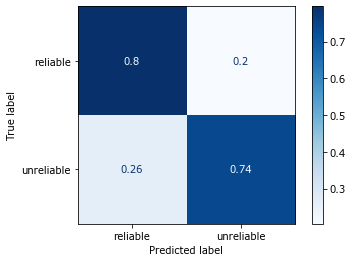

In [7]:
normalize = 'true'

true_preds, true_labels = [np.argmax(pred) for pred in model.predict(test_samples)], \
                          [np.argmax(label) for label in test_labels]
ConfusionMatrixDisplay.from_predictions(true_labels, true_preds, normalize=normalize,
                                        cmap=plt.cm.Blues, display_labels=('reliable', 'unreliable'))